In [1]:
#!pip install --no-index --upgrade pip

In [2]:
#!pip install --no-index numpy

In [3]:
#!pip install --no-index tensorflow-gpu

In [4]:
#!pip install --no-index matplotlib

In [5]:
import tensorflow as tf
#import tensorflow_addons as tfa
#import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import io
import unicodedata
import re
import gc
from collections import Counter
#import keras as k

In [6]:
#physical_devices = tf.config.list_physical_devices('GPU')
#physical_devices

In [7]:
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [8]:
tf.__version__

'1.15.0'

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import h5py
import os
import bilm
from bilm import Batcher, BidirectionalLanguageModel, weight_layers
import datetime as dt

Using TensorFlow backend.


## Preprocessing: Tokenize, clean-up, load, padding

### Tokenize and clean up data

In [10]:
# Lower case for the translation
# Load original english text as is
# install requirement.txt
# python -m spacy download fr_core_news_sm
# correction of tokenizer.py: add encoding='utf-8' to open method
# same thing for punctuation_remover.py
# python tokenizer.py --input train.lang2 --output tokenized --lang fr --keep-empty-lines
# python punctuation_remover.py --input train.lang2.tok --output tokenized


### Loading weights

In [11]:
# Load data
textdir = "data/train/"
fr_text_file = os.path.join(textdir, 'train.lang2')
en_text_file = os.path.join(textdir, 'train.lang1')

#FILE_NAMES = ["train.lang1","train.lang2"]
#ELMo_Embeddings = ["new_ELMo_input_en_embeddings.hdf5","ELMo_emb_fr.hdf5"]

datadir = "ELMo/"
Elmo_emb_dec_input_file = os.path.join(datadir, 'swb_fr/', 'ELMo_decoder_input_embeddings.hdf5')
Elmo_emb_dec_targets_file = os.path.join(datadir, 'swb_fr/', 'ELMo_decoder_output_embeddings.hdf5')

fr_vocab_file = os.path.join(datadir, 'swb_fr/', 'vocab.txt')
fr_options_file = os.path.join(datadir, 'swb_fr/', 'options_eval_fr.json')
fr_weight_file = os.path.join(datadir, 'swb_fr/', 'swb_weights_fr.hdf5')

Elmo_emb_enc_file = os.path.join(datadir, 'swb_en/', 'ELMo_encoder_embeddings_post.hdf5')
en_vocab_file = os.path.join(datadir, 'swb_en/', 'vocab.txt')
en_options_file = os.path.join(datadir, 'swb_en/', 'options_eval.json')
en_weight_file = os.path.join(datadir, 'swb_en/', 'swb_weights_en.hdf5')


SOS_ELMo_emb_file = os.path.join(datadir, '../', 'SOS_ELMo_emb.hdf5')


In [12]:
en_elmo_emb = h5py.File(Elmo_emb_enc_file, 'r')
fr_elmo_emb = h5py.File(Elmo_emb_dec_input_file, 'r')
#fr_elmo_emb_targets = h5py.File(Elmo_emb_dec_targets_file, 'r')

### Load vocabulary

In [13]:
en_vocab = []
with open(en_vocab_file, 'r', encoding='utf-8') as f:
    for line in f.readlines():
        line = line.rstrip().split('\n')
        en_vocab.append(line[0])
    f.close()

en_vocab = ['<PAD>'] + en_vocab
en_vocab[:10]

['<PAD>', '<S>', '</S>', '<UNK>', 'the', 'to', 'of', 'and', 'in', 'a']

In [14]:
en_word2idx = {v:k for k, v in enumerate(en_vocab)}
#print(en_word2idx)
num_words_input = len(en_word2idx)
print("Number of input lang tokens: ",num_words_input)

Number of input lang tokens:  165670


In [15]:
fr_vocab = []
with open(fr_vocab_file, 'r', encoding='utf-8') as f:
    for line in f.readlines():
        line = line.rstrip().split('\n')
        fr_vocab.append(line[0])
    f.close()

fr_vocab = ['<PAD>'] + fr_vocab
fr_vocab[:10]

['<PAD>', '<S>', '</S>', '<UNK>', 'de', '.', ',', 'la', 'et', 'le']

In [16]:
fr_word2idx = {v:k for k, v in enumerate(fr_vocab)}
fr_idx2word = {k:v for k, v in enumerate(fr_vocab)}
#print(fr_word2idx)
num_words_output = len(fr_word2idx)
print("Number of output lang tokens: ",num_words_output)

Number of output lang tokens:  83332


### Load ELMo embeddings

In [17]:
# Encoder embeddings
dset = list(en_elmo_emb.keys())[0]
encoder_input_sequences = en_elmo_emb[dset][()]
en_elmo_emb.close()

In [18]:
encoder_input_sequences.shape

(11000, 96, 256)

In [19]:
# max input sentence length
max_input_len = encoder_input_sequences.shape[1]
max_input_len

96

In [20]:
encoder_input_sequences[0]

array([[ 0.9377234 ,  0.11211856, -1.815702  , ..., -1.0165986 ,
         0.2566865 , -1.4266841 ],
       [ 0.76397216, -0.72957176, -1.2059255 , ..., -0.53055835,
        -0.28045744, -1.6430402 ],
       [-0.09817386, -2.4250271 ,  1.2986397 , ...,  0.80349994,
         0.70233214, -3.0202804 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

### Decoder input embeddings

In [21]:
# Decoder input embeddings
dset = list(fr_elmo_emb.keys())[0]
decoder_input_sequences = fr_elmo_emb[dset][()]
fr_elmo_emb.close()

In [22]:
decoder_input_sequences.shape

(11000, 113, 256)

In [23]:
# max input sentence length
max_out_len = decoder_input_sequences.shape[1]
max_out_len

113

In [24]:
decoder_input_sequences[0]

array([[-1.3515264 , -0.4155752 , -1.1044897 , ..., -0.6278715 ,
         1.9337945 , -1.7928498 ],
       [ 1.0957094 ,  0.7679421 ,  1.6110834 , ...,  0.3838907 ,
        -0.34145802,  1.4356495 ],
       [ 0.7996905 ,  0.6359963 ,  0.70580614, ..., -0.95944005,
         1.1262033 , -1.3790954 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

### Decoder targets

In [25]:
# Load french train text
decoder_target_text = []

with open(fr_text_file, 'r', encoding="UTF-8") as fr_file:
    for line in fr_file.readlines():
        line = line.rstrip().split('\n')

        target_line = line[0]+" </S>"
        #input_line = "<S> "+line[0]+"\n"

        #decoder_input_text.append(input_line)
        decoder_target_text.append(target_line)
    fr_file.close()

In [26]:
decoder_target_text[:3]

['L’ idée de concilier les différences religieuses semble donc dangereuse . </S>',
 'Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité . </S>',
 'La réticence doit laisser place à une politique stimulante . </S>']

In [27]:
# Tokenize text
tokenized_context = [sentence.split() for sentence in decoder_target_text]

In [28]:
#tokenized_context[1]

In [29]:
def get_idx_from_word(word, encode_dict):
    #print(encode_dict.get(word))
    if encode_dict.get(word)==None:
        if encode_dict.get(word.lower())==None:
            return encode_dict.get('<UNK>')
        else:
            return encode_dict.get(word.lower())
    else:
        return encode_dict.get(word)
    
def encode_sequence(seq, encode_dict):
    #print([j.lower() for j in seq])
    return [get_idx_from_word(j, encode_dict) for j in seq]

In [30]:
def get_word_from_idx(idx, decode_dict):
    if decode_dict.get(idx)==None:
        return '<UNK>'
    else:
        return decode_dict.get(idx)

def decode_sequence(seq, decode_dict):
    return [get_word_from_idx(j, decode_dict) for j in seq]

In [31]:
#idx = encode_sequence(tokenized_context[1],fr_word2idx)
#idx

In [32]:
idx = decode_sequence([0],fr_idx2word)
idx

['<PAD>']

In [33]:
# Build decoder targets
for i, seq in enumerate(tokenized_context):
    new_seq = pad_sequences([encode_sequence(seq, fr_word2idx)], padding='post', maxlen=max_out_len)
    if i==0:
        decoder_output_sequences = new_seq
    else:
        decoder_output_sequences = np.vstack((decoder_output_sequences, new_seq))
        
#decoder_output_sequences = numpy.array([numpy.array(xi) for xi in x])

decoder_output_sequences.shape



(11000, 113)

In [34]:
decoder_output_sequences[1]

array([   73,     9,    69,     6,   444,     8,   421,     6,    10,
        1116,   769,     3,     7,  1786,    13,   685,     4,    34,
         132,    22,    10,   179,    11,   662,     6,  4906,    19,
         195,    22,    50,   685,     8, 10181,    83,   705,     5,
           2,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [35]:
#decode_sequence(decoder_output_sequences[1],fr_idx2word)

### Define the seq2seq model

In [36]:
# configure problem
embedings_dim = encoder_input_sequences.shape[2]
hidden_units = 512
LR = 0.001
dropout = 0.4

In [37]:
embedings_dim, hidden_units, num_words_output, max_input_len, max_out_len, LR, dropout

(256, 512, 83332, 96, 113, 0.001, 0.4)

In [38]:
# Encoder
def seq2seq_model(embedings_dim, hidden_units, num_fr_tokens, max_input_len, max_out_len, LR, dropout):      
    
    encoder_inputs = layers.Input(shape=(max_input_len, embedings_dim,), name='encoder_input')
    #encoder_embeddings = layers.Embedding(num_en_tokens, embedings_dim, mask_zero=True)
    #encoder_embedded = encoder_embeddings(encoder_inputs)
    encoder_bilstm = layers.Bidirectional(layers.LSTM(hidden_units, return_state=True, dropout=dropout), name='encoder_BiLSTM')
    # Return states in addition to output
    output, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_inputs) # replace embeddings by the encoder input
    
    state_h = concatenate([forward_h, backward_h])
    state_c = concatenate([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    
    #encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Decoder
    decoder_inputs = layers.Input(shape=(max_out_len, embedings_dim,), name='decoder_input')
    #decoder_embeddings = layers.Embedding(num_fr_tokens, embedings_dim, mask_zero=True)
    #decoder_embedded = decoder_embeddings(decoder_inputs)

    # Pass the 2 states to a new LSTM layer, as initial state
    decoder_lstm = layers.LSTM(hidden_units*2, return_sequences=True, return_state=True, dropout=dropout, name='decoder_LSTM')
    decoder_outputs, _, _, = decoder_lstm(decoder_inputs, initial_state=encoder_states) #replace embeddings by decoder inputs

    decoder_dense = layers.Dense(num_fr_tokens, activation='linear', name='decoder_output')                     
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Set Optimizer
    #opt = tf.keras.optimizers.SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True) #Adam(learning_rate=LR)
    # k.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none'),

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-3), #momentum=0.9, nesterov=True),
                  metrics=['sparse_categorical_accuracy'],             
                 )
    model.summary()
    
    # Evaluation model:
    encoder_model = Model(encoder_inputs, encoder_states)
    
    decoder_state_h = layers.Input(shape=(hidden_units*2,))
    decoder_state_c = layers.Input(shape=(hidden_units*2,))
    #decoder_state_b_h = layers.Input(shape=(hidden_units,))
    #decoder_state_b_c = layers.Input(shape=(hidden_units,))
    
    #e_state_h = layers.Concatenate()([decoder_state_f_h, decoder_state_b_h])
    #e_state_c = layers.Concatenate()([decoder_state_f_c, decoder_state_b_c])
    
    decoder_states_inputs = [decoder_state_h, decoder_state_c]#, decoder_state_b_h, decoder_state_b_c]
    
    decoder_inputs_single = layers.Input(shape=(max_out_len, embedings_dim,)) #layers.Input(shape=(1,))
    #decoder_inputs_single_x = decoder_embeddings(decoder_inputs_single)
    decoder_outputs, h, c = decoder_lstm(decoder_inputs_single, initial_state=decoder_states_inputs)
    decoder_states = [h, c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs_single] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )
     
    
    return model, encoder_model, decoder_model

In [39]:
model, encoder_model, decoder_model = seq2seq_model(embedings_dim, hidden_units, num_words_output, max_input_len, max_out_len, LR, dropout)
graph = tf.get_default_graph()

W0418 16:39:43.262333 47064174883840 deprecation.py:506] From /home/guest142/env2/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0418 16:39:43.263807 47064174883840 deprecation.py:506] From /home/guest142/env2/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0418 16:39:43.264656 47064174883840 deprecation.py:506] From /home/guest142/env2/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 96, 256)]    0                                            
__________________________________________________________________________________________________
encoder_BiLSTM (Bidirectional)  [(None, 1024), (None 3149824     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 113, 256)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1024)         0           encoder_BiLSTM[0][1]             
                                                                 encoder_BiLSTM[0][3]         

### Train the model

In [40]:
batch_size = 20
epochs=20

In [41]:
weights_file = "ELMO_weights_TF1"+ dt.datetime.now().strftime("%Y%m%d-%H%M%S")+"_.hdf5"
history_file = "ELMO_history_TF1"+ dt.datetime.now().strftime("%Y%m%d-%H%M%S")
weights_file, history_file

('ELMO_weights_TF120200418-163945_.hdf5', 'ELMO_history_TF120200418-163945')

In [42]:
decoder_output_sequences.shape, encoder_input_sequences.shape, decoder_input_sequences.shape

((11000, 113), (11000, 96, 256), (11000, 113, 256))

In [43]:
decoder_output_sequences = np.expand_dims(decoder_output_sequences, -1)
decoder_output_sequences.shape

(11000, 113, 1)

In [44]:
len(encoder_input_sequences)*.8/20

440.0

In [45]:
#checkpointer = tf.compat.v2.keras.callbacks.ModelCheckpoint(filepath = weights_file, verbose=1, save_best_only=True)

history = model.fit([encoder_input_sequences, decoder_input_sequences],
                    decoder_output_sequences,
                    batch_size=batch_size,
                    epochs=epochs, 
                    #validation_steps=batch_size,
                    validation_split=0.2,
                    #callbacks=[checkpointer]
                   )



W0418 16:39:46.897715 47064174883840 deprecation.py:323] From /home/guest142/env2/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8800 samples, validate on 2200 samples
Epoch 1/20
8800/8800 [==============================] - 739s 84ms/sample - loss: 1.4211 - sparse_categorical_accuracy: 0.8211 - val_loss: 1.0330 - val_sparse_categorical_accuracy: 0.8405
Epoch 2/20
8800/8800 [==============================] - 734s 83ms/sample - loss: 0.9126 - sparse_categorical_accuracy: 0.8493 - val_loss: 0.8808 - val_sparse_categorical_accuracy: 0.8552
Epoch 3/20
8800/8800 [==============================] - 734s 83ms/sample - loss: 0.7718 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.8050 - val_sparse_categorical_accuracy: 0.8642
Epoch 4/20
8800/8800 [==============================] - 735s 83ms/sample - loss: 0.6803 - sparse_categorical_accuracy: 0.8680 - val_loss: 0.7607 - val_sparse_categorical_accuracy: 0.8706
Epoch 5/20
8800/8800 [==============================] - 735s 83ms/sample - loss: 0.6126 - sparse_categorical_accuracy: 0.8745 - val_loss: 0.7328 - val_sparse_categorical_accuracy: 0.8752
Epoch 6/20
8800/8

In [46]:
import pickle
with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [47]:
history2 = pickle.load(open(history_file, "rb"))

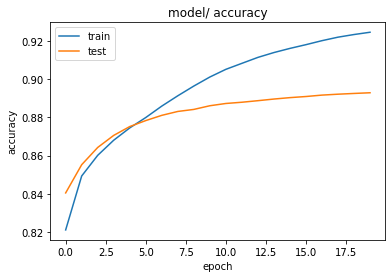

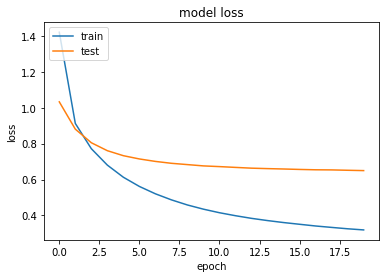

In [48]:
# summarize history for accuracy
plt.plot(history2['sparse_categorical_accuracy'])
plt.plot(history2['val_sparse_categorical_accuracy'])
plt.title('model/ accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
# Loads the weights
#model.load_weights('ELMO_weights_20200416-042652_.hdf5')

In [50]:
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file = "seq2seq_translation.png", show_shapes = True)

## Evaluation

In [51]:
def get_elmo_emb2(idx):
    return encoder_input_sequences[idx].reshape(-1,96,256)

In [52]:
get_elmo_emb2(0)

array([[[ 0.9377234 ,  0.11211856, -1.815702  , ..., -1.0165986 ,
          0.2566865 , -1.4266841 ],
        [ 0.76397216, -0.72957176, -1.2059255 , ..., -0.53055835,
         -0.28045744, -1.6430402 ],
        [-0.09817386, -2.4250271 ,  1.2986397 , ...,  0.80349994,
          0.70233214, -3.0202804 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)

In [53]:
def get_elmo_emb(input_seq, max_length, options_file, weight_file, vocab_file):
    tf.compat.v1.disable_eager_execution()
    tf.reset_default_graph()
    
    # Create a Batcher to map text to character ids.
    batcher = Batcher(vocab_file, 50)
 
    # Input placeholders to the biLM.
    context_character_ids = tf.compat.v1.placeholder('int32', shape=(None, None, 50))
 
    # Build the biLM graph.
    bilm = BidirectionalLanguageModel(options_file, weight_file)
 
    # Get ops to compute the LM embeddings.
    context_embeddings_op = bilm(context_character_ids)
     
    # Get an op to compute ELMo (weighted average of the internal biLM layers)
    elmo_context_input = weight_layers('input', context_embeddings_op, l2_coef=0.0)
    
    # Now we can compute embeddings.
    #print("get elmo: input_seq=",input_seq)
    tokenized_context = [input_seq.split()] # for sentence in input_seq]
    #print(tokenized_context)
    
    with tf.Session() as sess:
        # It is necessary to initialize variables once before running inference.
        sess.run(tf.global_variables_initializer())
 
        # Create batches of data.
        context_ids = batcher.batch_sentences(tokenized_context)
        #print("Shape of context ids = ", context_ids.shape)
 
        # Compute ELMo representations (here for the input only, for simplicity).
        elmo_context_input_ = sess.run(
            elmo_context_input['weighted_op'],
            feed_dict={context_character_ids: context_ids}
        )
    # Pad the output to max sequence length of the model
    elmo_emb = pad_sequences(elmo_context_input_, maxlen=max_length, padding='post', dtype='float32')
    #print("Shape of generated embeddings = ",elmo_emb.shape)
    return elmo_emb

In [54]:
def translate_sentence(idx, sentence):
    tf.compat.v1.disable_eager_execution()
    #tf.reset_default_graph()
    global graph
    graph = tf.get_default_graph()
    
    
    # Get ELMo embeddings
    print("Get ELMo context for the input sentence: ", sentence)
    input_seq = get_elmo_emb(sentence, max_input_len, en_options_file, en_weight_file, en_vocab_file)  # get ELMO embeddings calculated beforehand on input text
    #print(input_seq)
    
    # Get encoder states value
    print("Feed input context encoder model ...")
    with graph.as_default():
        states_value = encoder_model.predict(input_seq)
    #print("states_value=",states_value[0].shape)
    
    # Feed the decoder a token at the time, starting with <S> token
    print("Feed the decoder with start token ...")
    target_seq = get_elmo_emb('<S>', max_out_len, fr_options_file, fr_weight_file, fr_vocab_file) #['<S>']
    
    eos1 = fr_word2idx['</S>']
    eos2 = fr_word2idx['.']
    eos3 = fr_word2idx['<PAD>']
    output_sentence = []
    
    print("Translating the input ...")
    for _ in range(max_out_len):
        #print("Next target_seq=",target_seq.shape)
        with graph.as_default():
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])
        #print("new idx=",idx)
        
        if ((eos1 == idx) or (eos2 == idx) or (idx==0)):
            break
        else:
            word = decode_sequence([idx],fr_idx2word) #fr_idx2word(idx)
            output_sentence.append(word[0]+" ")
            #print("Predicting word "+str(word)+"for index "+str(idx))

        target_seq = get_elmo_emb(word[0],max_out_len, fr_options_file, fr_weight_file, fr_vocab_file)
        states_value = [h, c]
        
        

    return ' '.join(str(v) for v in output_sentence)

In [55]:
### Load test data
input_text = []
with open(en_text_file, 'r', encoding="UTF-8") as en_file:
    for line in en_file.readlines():
        line = line.rstrip().split('\n')
        input_text.append(line[0])
    en_file.close()

In [56]:
target_text = []
with open(fr_text_file, 'r', encoding="UTF-8") as fr_file:
    for line in fr_file.readlines():
        line = line.rstrip().split('\n')
        target_text.append(line[0])
    fr_file.close()

In [69]:
ids = np.random.randint(0,100,5)

In [70]:
targets = [target_text[i] for i in ids]

In [71]:
# Run prediction on 5 samples
predictions = []
for i in [0,1]:
    _, encoder_model, decoder_model = seq2seq_model(embedings_dim, hidden_units, num_words_output, max_input_len, max_out_len, LR, dropout)
    graph = tf.get_default_graph()
    print('==============================')
    #print('Input:', input_text[i])
    translation = translate_sentence(i, input_text[i])
    print('Response:', )
    predictions.append(translation+'\n')
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 96, 256)]    0                                            
__________________________________________________________________________________________________
encoder_BiLSTM (Bidirectional)  [(None, 1024), (None 3149824     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 113, 256)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1024)         0           encoder_BiLSTM[0][1]             
                                                                 encoder_BiLSTM[0][3]         

In [72]:
with open("targets.txt", "w", encoding='utf-8') as target_file:
    target_file.writelines(target_text)
    target_file.close()

In [73]:
with open("predictions.txt", "w", encoding='utf-8') as target_file:
    target_file.writelines(predictions)
    target_file.close()

## SacreBLEU Evaluation 

In [63]:
!python evaluator.py --input-file-path predictions.txt --target-file-path targets.txt --do-not-run-model

Traceback (most recent call last):
  File "evaluator.py", line 71, in <module>
    main()
  File "evaluator.py", line 63, in main
    compute_bleu(args.input_file_path, args.target_file_path, args.print_all_scores)
  File "evaluator.py", line 40, in compute_bleu
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.7.4/lib/python3.7/subprocess.py", line 472, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.7.4/lib/python3.7/subprocess.py", line 775, in __init__
    restore_signals, start_new_session)
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.7.4/lib/python3.7/subprocess.py", line 1522, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
FileNotFoundError: [Errno 2] No such file or directory: 'sacrebleu': 'sacrebleu'


['0.0', '']
final avg bleu score: 0.00